In [1]:
# All imports should be in first cell
import imp  
import inspect
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Inspect the generated topography

(2240, 2880)


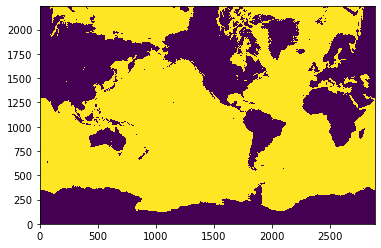

In [2]:
targ_topo =  netCDF4.Dataset('/work/Niki.Zadeh/MOM6-examples_myfork/ice_ocean_SIS2/OM4_0125/preprocessing_GB2020/topog_merged.nc')
targ_havg = np.array(targ_topo.variables['height'])
targ_hmin = np.array(targ_topo.variables['h_min'])
targ_hmax = np.array(targ_topo.variables['h_max'])
#targ_x = np.array(targ_topo.variables['x'])
#targ_y = np.array(targ_topo.variables['y'])
targ_wet=np.zeros(targ_havg.shape)
targ_wet=np.where(targ_havg<0.,1.0,0.0)
print(targ_havg.shape)
#plt.pcolormesh(targ_x,targ_y,targ_wet);
plt.pcolormesh(targ_wet);

In [3]:
def ice9it(i,j,depth):
  # Iterative implementation of "ice 9"
  wetMask = 0*depth
  (nj,ni) = wetMask.shape
  stack = set()
  stack.add( (j,i) )
  while stack:
    (j,i) = stack.pop()
    if wetMask[j,i] or depth[j,i] >= 0: continue
    wetMask[j,i] = 1
    if i>0: stack.add( (j,i-1) )
    else: stack.add( (j,ni-1) )
    if i<ni-1: stack.add( (j,i+1) )
    else: stack.add( (0,j) )
    if j>0: stack.add( (j-1,i) )
    if j<nj-1: stack.add( (j+1,i) )
    else: stack.add( (j,ni-1-i) )
  return wetMask

## Use ice9 algorithm to produce wet mask
### Note Black Sea is missing if we use  h_avg to produce wet mask 

In [4]:
iseed,jseed = 10,1000 #indices of any point that you know should be wet 
ice9_wetavg = ice9it(iseed,jseed,targ_havg)

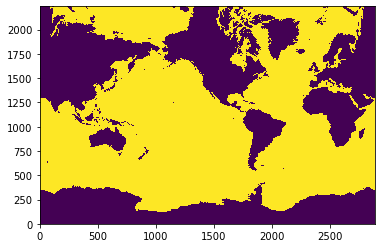

In [5]:
plt.pcolormesh(ice9_wetavg);

### Note Black Sea appears  if we instead use  h_min to produce wet mask 

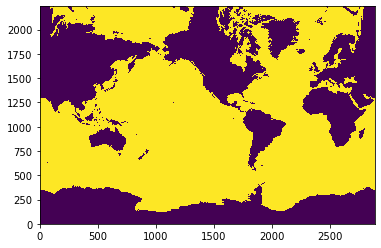

In [6]:
ice9_wet_min = ice9it(iseed,jseed,targ_hmin)
plt.pcolormesh(ice9_wet_min);

In [7]:
def get_indices(lon_grid,lat_grid,x,y):
    """This function returns the j,i indices for the grid point closest to the input lon,lat coordinates."""
    """It returns the j,i indices."""
    lons=np.fabs(lon_grid-x)
    lonm=np.where(lons==lons.min())
    lats=np.fabs(lat_grid-y)
    latm=np.where(lats==lats.min())
    j0=latm[0][0]
    i0=lonm[1][0]
    print("wanted: ",x,y)
    print("got:    ",lon_grid[j0,i0] , lat_grid[j0,i0])
    print(j0,i0)
    return j0,i0

#Zoom in on Black Sea channel
#j0,i0=get_indices(targ_x, targ_y ,29.03, 41.04)
#di0,dj0=40,20
#im,ip = i0-di0, i0+di0
#jm,jp = j0-dj0, j0+dj0
#plt.pcolormesh(targ_wet[jm:jp,im:ip])